In [16]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_dir = "./dataset2"


In [17]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(100, 100),
  batch_size=32)

Found 7689 files belonging to 7 classes.
Using 6152 files for training.


In [18]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(100, 100),
  batch_size=32)

Found 7689 files belonging to 7 classes.
Using 1537 files for validation.


In [19]:
class_names = train_ds.class_names
print(class_names)

['abstract_images', 'daisy', 'dandelion', 'non_abstract_images', 'rose', 'sunflower', 'tulip']


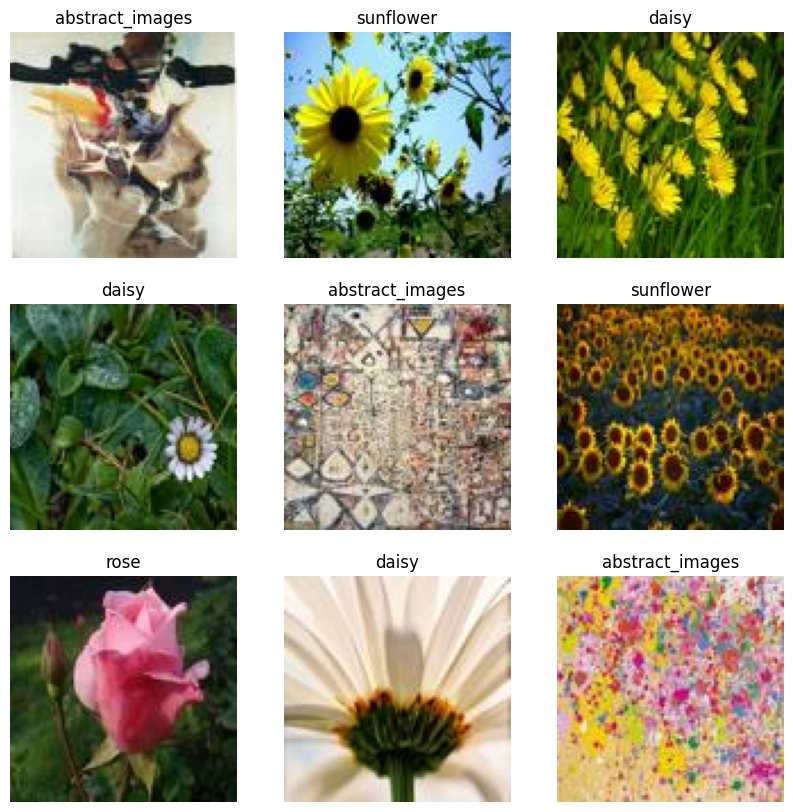

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [23]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 64)       

In [26]:
epochs= 1000
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=.01 ,verbose=1, patience=3)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [es]
)

Epoch 1/1000
193/193 [==============================] - 24s 119ms/step - loss: 1.3421 - accuracy: 0.5057 - val_loss: 1.1353 - val_accuracy: 0.5621
Epoch 2/1000
193/193 [==============================] - 24s 122ms/step - loss: 0.9472 - accuracy: 0.6601 - val_loss: 0.8465 - val_accuracy: 0.6994
Epoch 3/1000
193/193 [==============================] - 26s 137ms/step - loss: 0.8038 - accuracy: 0.7125 - val_loss: 0.8195 - val_accuracy: 0.7241
Epoch 4/1000
193/193 [==============================] - 26s 135ms/step - loss: 0.7039 - accuracy: 0.7469 - val_loss: 0.7672 - val_accuracy: 0.7437
Epoch 5/1000
193/193 [==============================] - 26s 134ms/step - loss: 0.6277 - accuracy: 0.7741 - val_loss: 0.7415 - val_accuracy: 0.7495
Epoch 6/1000
193/193 [==============================] - 30s 157ms/step - loss: 0.5517 - accuracy: 0.7996 - val_loss: 0.8145 - val_accuracy: 0.7215
Epoch 7/1000
193/193 [==============================] - 29s 152ms/step - loss: 0.4672 - accuracy: 0.8405 - val_loss: 0

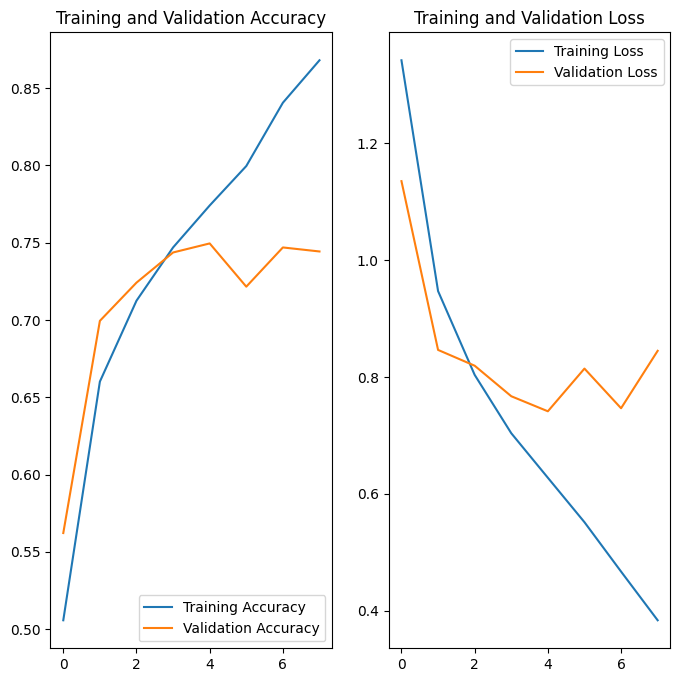

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#save the model
model.save("my_model")

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


In [30]:
#test prediction with the model
print("abstract_image: ")
img = tf.keras.utils.load_img("./dataset2/abstract_images/abstract_image" + str(0) + ".jpg")
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
print(predictions)

print("non_abstract_image: ")
img = tf.keras.utils.load_img("./dataset2/non_abstract_images/non_abstract_image" + str(0) + ".jpg")
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
print(predictions)

flowers = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
for flower in flowers:
    print(flower + ":")
    img = tf.keras.utils.load_img('./dataset2/' + flower + '/' + flower + str(0) + '.jpg')
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    print(predictions)

abstract_image: 
1/1 [==============================] - 0s 24ms/step
[[ 20.87258    -3.754381   -1.9752332 -28.190819   -1.7906708  -2.5064404
    1.874118 ]]
non_abstract_image: 
1/1 [==============================] - 0s 29ms/step
[[  6.201447   -1.2614422 -10.763462   12.778401   -3.3920357  -8.356903
   -4.2457356]]
daisy:
1/1 [==============================] - 0s 25ms/step
[[-0.98512954  3.9037788   2.3766158  -7.997679   -0.16440126  1.9396377
  -0.45074606]]
dandelion:
1/1 [==============================] - 0s 16ms/step
[[ -3.2844799    3.4400032    9.64761    -16.916557     2.3199148
   -0.66564757  -1.5051157 ]]
rose:
1/1 [==============================] - 0s 19ms/step
[[ -2.4543226   5.934028   -0.7348047 -20.03283     9.517111   -0.7782551
    3.6837301]]
sunflower:
1/1 [==============================] - 0s 25ms/step
[[  2.6197875    0.03462123  -0.28937572 -10.830279     0.4021669
    6.014429     4.4443626 ]]
tulip:
1/1 [==============================] - 0s 24ms/step
[[ -0.